In [1]:
from os.path import join
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIR = '../data/01_processed'

In [2]:
tracking = pd.read_parquet(join(DATA_DIR, 'tracking.parquet'))
plays = pd.read_parquet(join(DATA_DIR, 'plays.parquet'))
games = pd.read_parquet(join(DATA_DIR, 'games.parquet'))
player_play = pd.read_parquet(join(DATA_DIR, 'player_play.parquet'))

# 1. Aggregate field control within RB vision cone
Apply this over the frames until the rb passes beyond the oline influence, to quantify how much space the rb has to run through. One possible limitation to this approach is rb skill will also likely lead to more open space, due to better vision, speed, or agility.

#### Calculate the euclidean distance from the ball carrier to each player for each frame 

In [3]:
rb_coords = (
    tracking[tracking['is_ball_carrier'] == 1]
    .set_index(['game_play_id', 'frame_id'])[['x', 'y']]
    .rename(columns={'x': 'ball_carrier_x', 'y': 'ball_carrier_y'})
)

tracking = tracking.merge(
    rb_coords,
    left_on=['game_play_id', 'frame_id'],
    right_index=True,
    how='left'
)

tracking['euclidean_dist_to_ball_carrier'] = (
    ((tracking['x'] - tracking['ball_carrier_x']) ** 2 +
     (tracking['y'] - tracking['ball_carrier_y']) ** 2) ** 0.5
).round(2)

tracking.drop(columns=['ball_carrier_x', 'ball_carrier_y'], inplace=True)

#### Find the closest offensive player to each defender. Mark the defender as engaged if they are within 3 feet of the offensive player

In [4]:
defenders = tracking[(tracking['offense'] == 0) & (tracking['club'] != 'football')].copy()
offense = tracking[(tracking['offense'] == 1) & (tracking['club'] != 'football')].copy()

defenders = defenders.rename(columns={'nfl_id': 'def_nfl_id', 'x': 'def_x', 'y': 'def_y'})
offense = offense.rename(columns={'nfl_id': 'off_nfl_id', 'x': 'off_x', 'y': 'off_y'})

merged = defenders.merge(
    offense[['game_play_id', 'frame_id', 'off_nfl_id', 'off_x', 'off_y']],
    on=['game_play_id', 'frame_id'],
    how='left'
)

merged['dist'] = np.sqrt((merged['def_x'] - merged['off_x'])**2 + (merged['def_y'] - merged['off_y'])**2)

merged = merged.sort_values(['game_play_id', 'frame_id', 'def_nfl_id', 'dist'])

# Get closest offensive player to each defender
closest = merged.loc[
    merged.groupby(['game_play_id', 'frame_id', 'def_nfl_id'])['dist'].idxmin(),
    ['game_play_id', 'frame_id', 'def_nfl_id', 'def_x', 'def_y', 
     'off_nfl_id', 'off_x', 'off_y', 'dist']
].copy()

# Rename columns
closest = closest.rename(columns={
    'off_x': 'x_closest_off_player',
    'off_y': 'y_closest_off_player',
    'off_nfl_id': 'closest_off_nfl_id',
    'dist': 'closest_off_dist'
})

# Mark engagement (3 feet == 1 yard)
closest['engaged'] = closest['closest_off_dist'] < 1

# Merge back to original tracking data
tracking = tracking.merge(
    closest[['game_play_id', 'frame_id', 'def_nfl_id', 'x_closest_off_player', 'y_closest_off_player', 'engaged']],
    left_on=['game_play_id', 'frame_id', 'nfl_id'],
    right_on=['game_play_id', 'frame_id', 'def_nfl_id'],
    how='left'
).drop(columns=['def_nfl_id'])

tracking['engaged'] = tracking['engaged'].fillna(False).astype(bool)

In [5]:
tracking.position_by_loc.value_counts(normalize=True)

CB     0.111145
WR     0.104182
TE     0.067632
OLB    0.066414
DT     0.065638
DE     0.064903
ILB    0.063432
FS     0.050935
RB     0.046968
SS     0.046252
QB     0.045468
RG     0.045455
C      0.045455
LG     0.045455
LT     0.045455
RT     0.045455
NT     0.019420
MLB    0.011034
FB     0.008451
LB     0.000641
DB     0.000212
Name: position_by_loc, dtype: float64

In [6]:
tracking.query('position_by_loc.isin(["OLB","DT","DE","ILB","NT","MLB","LB"])').engaged.value_counts(normalize=True)

True     0.575566
False    0.424434
Name: engaged, dtype: float64

#### Field Control functions

In [7]:
def influence(
        p: np.ndarray,
        p_i: np.ndarray,
        s: float,
        theta: float,
        rb_dist: float,
        is_offense: bool,
    ):
    '''
    Calculate the influence of a player on a point in the field.

    Args:
        p: coordinates of the point in the field.
        p_i: coordinates of the player.
        s: speed of the player.
        theta: direction of the player in radians.
        rb_dist: distance to the ball carrier.
        is_offense: boolean indicating if the player is on offense.
    Returns:    
        Influence value at the point.
    '''
    influence = (
        _bivariate_gaussian_pdf(p, p_i, s, theta, rb_dist) /
        _bivariate_gaussian_pdf(p_i, p_i, s, theta, rb_dist)
    )

    if is_offense:
        return influence
    return -influence

def _piecewise_function(x):
    """ Function reduces influence area radius if a player is closer to the rb """
    if x <= 18:
        return 0.01854*x**2 + 4  # Parabola for x <= 18
    else:
        return 10  # Flat line at y = 10 for x > 18

def _rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])

def _speed_ratio(s):
    return s**2 / 13**2
    
def _scaling_matrix(rb_dist, s):
    R = _piecewise_function(rb_dist)
    s_ratio = _speed_ratio(s)
    s_x = (R + (R * s_ratio)) / 2
    s_y = (R - (R * s_ratio)) / 2
    return np.array([[s_x,0],[0,s_y]])

def _mu(p_i, s_vect):
    s_unit_vector = s_vect / np.linalg.norm(s_vect)
    return p_i + (.5 * s_unit_vector)

def _cov(theta, rb_dist, s):
    S = _scaling_matrix(rb_dist, s)
    R = _rotation_matrix(theta)
    return R @ S @ S @ np.linalg.inv(R)

def _bivariate_gaussian_pdf(
    p: np.ndarray,
    p_i: np.ndarray,
    s: float,
    theta: float,
    rb_dist: float
):
    """
    Calculate the bivariate Gaussian PDF for a point in the field.
    
    Args:
        p: coordinates of the point in the field (2D vector).
        p_i: coordinates of the player (2D vector).
        s: player speed (float).
        theta: direction of motion in radians.
        rb_dist: Euclidean distance to the ball carrier.
        
    Returns:
        Float: PDF value at point p.
    """
    s_x = s * np.cos(theta)
    s_y = s * np.sin(theta)
    s_vect = np.array([s_x, s_y])
    
    mu = _mu(p_i, s_vect)
    sigma = _cov(theta, rb_dist, s)
    
    diff = p - mu
    constant = 1 / (2 * np.pi * np.sqrt(np.linalg.det(sigma)))
    exponent = -0.5 * diff.T @ np.linalg.inv(sigma) @ diff
    return constant * np.exp(exponent)

#### Visualize the field control within the ball carriers vision cone. This is filtered down to the frames of a play where the oline blocking has the greatest effect

In [72]:
plays.query('game_play_id == "2022091105_1742"').play_description.values[0]

'(:38) (Shotgun) R.Burkhead right guard to HST 19 for 5 yards (K.Paye).'

In [66]:
tracking.game_play_id.unique()[200:300]

array(['2022091106_154', '2022091106_175', '2022091106_338',
       '2022091106_359', '2022091106_499', '2022091106_586',
       '2022091106_607', '2022091106_752', '2022091106_883',
       '2022091106_904', '2022091106_1019', '2022091106_1297',
       '2022091106_1798', '2022091106_1874', '2022091106_1919',
       '2022091106_2090', '2022091106_2116', '2022091106_2170',
       '2022091106_2539', '2022091106_2605', '2022091106_2626',
       '2022091106_2864', '2022091106_2935', '2022091106_3002',
       '2022091106_3361', '2022091106_3399', '2022091105_56',
       '2022091105_101', '2022091105_166', '2022091105_228',
       '2022091105_273', '2022091105_358', '2022091105_403',
       '2022091105_424', '2022091105_527', '2022091105_667',
       '2022091105_711', '2022091105_732', '2022091105_1008',
       '2022091105_1050', '2022091105_1093', '2022091105_1194',
       '2022091105_1215', '2022091105_1330', '2022091105_1480',
       '2022091105_1742', '2022091105_1996', '2022091105_2021',

In [80]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from shapely import MultiPoint
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable

game_play_id = '2022091105_1742'

df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
frame_ids = sorted(df_all['frame_id'].unique())
yardline = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

field_control_granularity = 1
xmin, xmax = 0, 53.3

# Create a wider figure to accommodate the legend and colorbar
fig, ax = plt.subplots(figsize=(14, 8))

def create_mesh(df):
    ybuffer = 1
    ymin, ymax = df['y'].min() - ybuffer, df['y'].max() + ybuffer
    X, Y = np.meshgrid(np.arange(xmin, xmax + field_control_granularity, field_control_granularity),
                       np.arange(ymin, ymax + field_control_granularity, field_control_granularity))
    coords = np.column_stack([X.ravel(), Y.ravel()]).reshape((X.shape[0], X.shape[1], 2))
    return X, Y, coords

def compute_field_control(frame_df, coords):
    smoothing_param = sys.float_info.epsilon
    grid_shape = coords.shape[:2]
    field_control = np.zeros(grid_shape)

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier',
            'x_closest_off_player', 'y_closest_off_player', 'engaged']
    for i, row_coords in enumerate(coords):
        for j, coord in enumerate(row_coords):
            for row in frame_df[cols].itertuples(index=False):
                scale = 1
                if row.engaged:
                    defender_pos = np.array([row.x, row.y])
                    off_player_pos = np.array([row.x_closest_off_player, row.y_closest_off_player])
                    point_pos = np.array(coord)
                    vec_def_to_off = off_player_pos - defender_pos
                    vec_point_to_off = off_player_pos - point_pos
                    angle = np.degrees(np.arccos(
                        np.dot(vec_def_to_off, vec_point_to_off) /
                        (np.linalg.norm(vec_def_to_off) * np.linalg.norm(vec_point_to_off) + 1e-8)
                    ))
                    scale = ((180 - angle) / 180) ** .5
                    scale = np.clip(scale, 0, 1)
                    
                field_control[i, j] += scale * influence(
                    p=coord,
                    p_i=np.array([row.x, row.y]),
                    s=row.s + smoothing_param,
                    theta=row.dir * np.pi / 180,
                    rb_dist=row.euclidean_dist_to_ball_carrier,
                    is_offense=row.offense
                )

    return 1 / (1 + np.exp(-field_control))

def get_vision_cone(rb_pos, rb_dir_rad, rb_speed, cone_angle_deg=120, min_length=3, speed_factor=0):
    cone_length = min_length + rb_speed * speed_factor
    
    t = np.linspace(-np.radians(cone_angle_deg/2), np.radians(cone_angle_deg/2), 20)
    ellipse_x = cone_length * np.cos(t)
    ellipse_y = cone_length * np.sin(t) * 0.7
    
    points = np.column_stack([np.concatenate([[0], ellipse_x]),
                             np.concatenate([[0], ellipse_y])])
    
    rot_matrix = np.array([[np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
                          [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]])
    rotated_points = (rot_matrix @ points.T).T
    
    return rotated_points + rb_pos

def calculate_fc(fc, coords, polygons):
    combined_mask = np.zeros(coords.shape[:2], dtype=bool)
    for vertices in polygons:
        path = Path(vertices)
        mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
        combined_mask |= mask
    return fc[combined_mask].mean() if np.any(combined_mask) else 0

# Calculate global limits once
ymin_global = df_all['y'].min() - 1
ymax_global = df_all['y'].max() + 1

X_global, Y_global, coords_global = create_mesh(df_all)

def update(frame_id):
    ax.clear()
    frame_df = df_all[df_all['frame_id'] == frame_id]

    fc = compute_field_control(frame_df, coords_global)

    # Plot FC map with colorbar
    im = ax.imshow(fc, extent=[xmin, xmax, ymin_global, ymax_global],
              origin='lower', cmap="RdYlGn", alpha=0.5, aspect='auto', zorder=0, vmin=0, vmax=1)

    # Convex hull of O-line
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='darkgreen', linewidth=2, label='Convex Hull of O-Line')

    # RB vision cone
    rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
    if not rb_data.empty:
        rb = rb_data.iloc[0]
        rb_pos = np.array([rb.x, rb.y])
        rb_dir_rad = rb.dir * np.pi / 180
        rb_speed = rb.s

        cone_vertices = get_vision_cone(rb_pos, rb_dir_rad, rb_speed)
        ax.add_patch(plt.Polygon(cone_vertices, color='black', alpha=0.8, linewidth=2, fill=False))

        combined_fc = calculate_fc(fc, coords_global, [cone_vertices])
        ax.text(0.02, 0.95, f"Current FC in Cone: {combined_fc:.2f}",
                transform=ax.transAxes, fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7))

    ax.plot([], [], color='black', alpha=0.8, linewidth=2, label='RB Vision Cone', zorder=3)

    oline = frame_df[frame_df['is_part_of_oline']]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    defense = frame_df[(frame_df['offense'] == 0)]
    offense = frame_df[(frame_df['offense'] == 1) & (~frame_df['is_part_of_oline'])]

    ax.scatter(oline['x'], oline['y'], label='O-Line', s=50, color='darkgreen', zorder=2)
    ax.scatter(rb['x'], rb['y'], label='Ball Carrier', s=50, color='#001A00', zorder=4)
    ax.scatter(defense['x'], defense['y'], label='Defense', s=50, color='red', zorder=2)
    ax.scatter(offense['x'], offense['y'], label='Offense', s=50, color='#5CFF5C', zorder=2)

    ax.hlines(yardline, 0, 53.3, color='#436ee6', linestyle='-', label='Line of Scrimmage', lw=2, zorder=1)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin_global, ymax_global)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xticks([])
    ax.set_xticklabels([])

    # turn off legend
    ax.legend().set_visible(False)

    # plot the rb path across all frames
    rb_path = df_all[df_all['is_ball_carrier'] == 1][['x', 'y']].values
    ax.plot(rb_path[:, 0], rb_path[:, 1], color='black', linestyle='--', linewidth=1, alpha=0.7, label='RB Path', zorder=1)
    
    # Adjust legend position to be inside the plot in the upper right
    # ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1), borderaxespad=0.)

# Tight layout to prevent overlap
fig.tight_layout()

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

# Save the animation as a gif
# import os
# os.makedirs('../data/images/gifs', exist_ok=True)
# ani.save(join('../data/images/gifs', 'field_control.gif'), writer='pillow', fps=5)

In [76]:
tracking.s.describe()

count    2.577127e+06
mean     2.800928e+00
std      1.671772e+00
min      0.000000e+00
25%      1.450000e+00
50%      2.590000e+00
75%      3.940000e+00
max      2.211000e+01
Name: s, dtype: float64

In [17]:
import numpy as np
from matplotlib.path import Path
# ['SS', 'QB', 'RG', 'CB', 'OLB', 'WR', 'DE', 'ILB', 'FS', 'C', 'NT',
#        'RB', 'TE', 'LG', 'LT', 'RT', None, 'DT', 'MLB', 'FB', 'LB', 'DB']
def_positions = ['SS', 'CB', 'OLB', 'DE', 'ILB', 'FS', 'NT',
      'DT', 'MLB', 'LB', 'DB']
off_positions = ['QB', 'WR', 'TE', 'RB', 'FB', 'C', 'LG', 'RG', 'LT', 'RT']
tracking['defense'] = tracking['position_by_loc'].isin(def_positions)

def calculate_play_rb_field_control(game_play_id, cone_granularity=0.1):
    """Calculate average field control in RB's merged vision+semicircle polygon, 
    with engaged scaling factor applied."""
    smoothing_param = sys.float_info.epsilon
    
    df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
    frame_ids = sorted(df_all['frame_id'].unique())
    cone_stats = {'frame_values': [], 'average': 0}
    
    for frame_id in frame_ids:
        frame_df = df_all[df_all['frame_id'] == frame_id]
        rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
        
        if not rb_data.empty:
            rb = rb_data.iloc[0]
            rb_pos = np.array([rb.x, rb.y])
            rb_dir_rad = rb.dir * np.pi / 180
            rb_speed = rb.s
            
            # Build merged cone+circle shape
            cone_vertices = get_rb_vision_plus_circle(rb_pos, rb_dir_rad, rb_speed)
            path = Path(cone_vertices)
            
            # Grid around the polygon
            cone_buffer = 2  # yards buffer
            x_min, x_max = cone_vertices[:, 0].min() - cone_buffer, cone_vertices[:, 0].max() + cone_buffer
            y_min, y_max = cone_vertices[:, 1].min() - cone_buffer, cone_vertices[:, 1].max() + cone_buffer
            
            X = np.arange(x_min, x_max + cone_granularity, cone_granularity)
            Y = np.arange(y_min, y_max + cone_granularity, cone_granularity)
            X, Y = np.meshgrid(X, Y)
            coords = np.column_stack([X.ravel(), Y.ravel()])
            
            # Keep only points inside the polygon
            mask = path.contains_points(coords)
            cone_coords = coords[mask]
            
            if len(cone_coords) > 0:
                fc_values = np.zeros(len(cone_coords))
                
                cols = [
                    'x', 'y', 's', 'dir', 'offense',
                    'euclidean_dist_to_ball_carrier',
                    'x_closest_off_player', 'y_closest_off_player', 'engaged',
                    # 'defense'
                ]
                
                for i, coord in enumerate(cone_coords):
                    for row in frame_df[cols].itertuples(index=False):
                        # Only consider defenders
                        # if not row.defense:
                        #     continue

                        # scale = 1
                        
                        # Engaged scaling factor
                        # if row.engaged:
                        #     defender_pos = np.array([row.x, row.y])
                        #     off_player_pos = np.array([row.x_closest_off_player, row.y_closest_off_player])
                        #     point_pos = np.array(coord)
                            
                        #     vec_def_to_off = off_player_pos - defender_pos
                        #     vec_point_to_off = off_player_pos - point_pos
                            
                        #     # Avoid division by zero
                        #     dot_prod = np.dot(vec_def_to_off, vec_point_to_off)
                        #     norm_prod = (np.linalg.norm(vec_def_to_off) * np.linalg.norm(vec_point_to_off) + 1e-8)
                        #     angle = np.degrees(np.arccos(dot_prod / norm_prod))
                            
                        #     # Scale factor (0 at 180°, 1 at 0°), smoothed by sqrt
                        #     scale = ((180 - angle) / 180) ** 0.5
                        #     scale = np.clip(scale, 0, 1)
                        
                        # fc_values[i] += scale * influence(
                        fc_values[i] += influence(
                            p=coord,
                            p_i=np.array([row.x, row.y]),
                            s=row.s + smoothing_param,
                            theta=row.dir * np.pi / 180,
                            rb_dist=row.euclidean_dist_to_ball_carrier,
                            is_offense=row.offense
                        )
                
                # Apply sigmoid to FC values
                fc_values = 1 / (1 + np.exp(-fc_values))
                cone_stats['frame_values'].append(fc_values.mean())
    
    if cone_stats['frame_values']:
        cone_stats['average'] = np.mean(cone_stats['frame_values'])
    
    return cone_stats['average']

def get_rb_vision_plus_circle(rb_pos, rb_dir_rad, rb_speed, radius=2, cone_angle_deg=45, num_points=50):
    """
    Returns a single polygon that merges the RB's vision cone with the surrounding semicircle
    so there's no overlap or double counting.
    """
    # --- Vision cone ---
    cone_length = 3 + rb_speed * 0.3
    t_cone = np.linspace(-np.radians(cone_angle_deg/2), np.radians(cone_angle_deg/2), num_points//2)
    cone_x = cone_length * np.cos(t_cone)
    cone_y = cone_length * np.sin(t_cone) * 0.7
    cone_points = np.column_stack([cone_x, cone_y])

    # --- Arc for rest of the circle ---
    excluded_half_angle = np.radians(cone_angle_deg/2)
    arc_angles = np.linspace(excluded_half_angle, 2*np.pi - excluded_half_angle, num_points)
    arc_x = radius * np.cos(arc_angles)
    arc_y = radius * np.sin(arc_angles)
    arc_points = np.column_stack([arc_x, arc_y])

    # Combine so the shape wraps around:
    # Start at cone tip left edge, go around the back arc, and end at cone tip right edge
    combined_points = np.vstack([
        [0, 0],  # RB center
        cone_points[0],       # left edge of cone
        arc_points,           # around back
        cone_points[-1],      # right edge of cone
        [0, 0]                # close back to RB
    ])

    # Rotate to RB direction
    rot_matrix = np.array([[np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
                           [np.sin(rb_dir_rad),  np.cos(rb_dir_rad)]])
    rotated_points = (rot_matrix @ combined_points.T).T

    return rotated_points + rb_pos


# Process all plays
play_results = {}
week_1_game_ids = games.query('week == 1')['game_id'].unique().tolist()
week_1_game_play_ids = plays.query('game_id in @week_1_game_ids')['game_play_id'].unique().tolist()
for game_play_id in tqdm(week_1_game_play_ids, desc='Calculating Field Control in Cones for week 1', total=len(week_1_game_play_ids)):
    avg_fc = calculate_play_rb_field_control(game_play_id, cone_granularity=0.5)
    play_results[game_play_id] = avg_fc

Calculating Field Control in Cones for week 1: 100%|██████████| 438/438 [13:09<00:00,  1.80s/it]


When scaling defender to blocker angle -> r2 of 0.088 verse 0.105 when not scaling defender influence

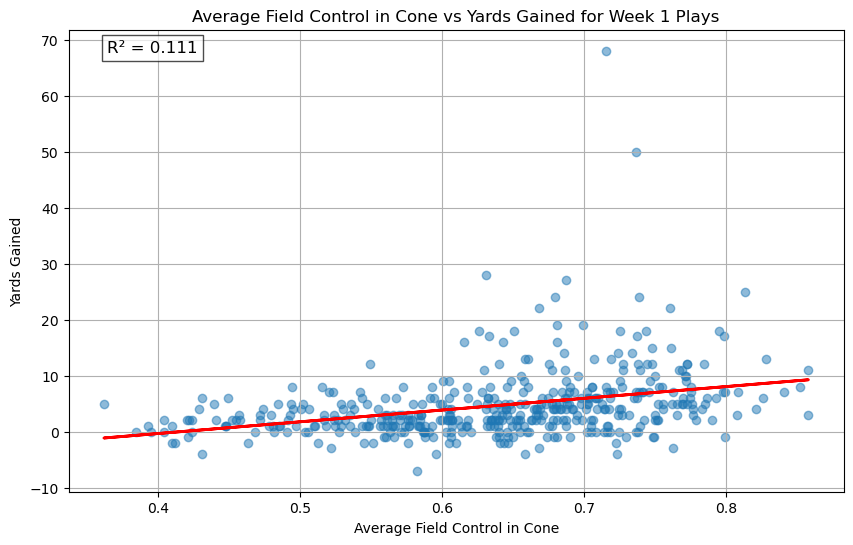

In [18]:
# plot the relationship
import matplotlib.pyplot as plt

plays_wk1 = plays.merge(
    pd.DataFrame.from_dict(play_results, orient='index', columns=['avg_field_control_in_cone']),
    left_on='game_play_id',
    right_index=True,
    how='left'
).dropna(subset=['avg_field_control_in_cone'])

x = 'avg_field_control_in_cone'

plt.figure(figsize=(10, 6))
plt.scatter(plays_wk1[x], plays_wk1['yards_gained'], alpha=0.5)
# best fit line
m, b = np.polyfit(plays_wk1[x], plays_wk1['yards_gained'], 1)
plt.plot(plays_wk1[x], m * plays_wk1[x] + b, color='red', linewidth=2, label='Best Fit Line')
# plot r squared
r2 = np.corrcoef(plays_wk1[x], plays_wk1['yards_gained'])[0, 1] ** 2
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('Average Field Control in Cone vs Yards Gained for Week 1 Plays')
plt.xlabel('Average Field Control in Cone')
plt.ylabel('Yards Gained')
plt.grid()
plt.show()

In [19]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(plays_wk1['avg_field_control_in_cone'], plays_wk1['yards_gained'])
print(f"p-value: {p_value:.20f}")

p-value: 0.00000000000087301670


In [81]:
DATA_DIR = '../data/01_processed'
tracking = pd.read_parquet(join(DATA_DIR, 'tracking.parquet'))

tracking.head()

,game_play_id,game_id,play_id,nfl_id,display_name,frame_id,frame_type,time,club,play_direction,x,y,s,a,dis,o,dir,event,euclidean_dist_to_ball,lateral_distance_to_ball,vertical_dist_to_ball,is_ball_carrier,roster_position,position_by_loc,offense,extra_on_oline,is_part_of_oline,breakthrough_frameid,first_frame
0,2022091200_64,2022091200,64,35459.0,Kareem Jackson,124,AFTER_SNAP,2022-09-13 00:16:15.8,DEN,right,25.65,52.30,4.08,2.21,0.39,333.63,42.25,None,19.45,-7.02,18.14,0,SS,SS,0,False,False,NaN,114
1,2022091200_64,2022091200,64,35459.0,Kareem Jackson,125,AFTER_SNAP,2022-09-13 00:16:15.9,DEN,right,25.96,52.58,4.27,2.00,0.42,334.98,40.16,None,20.16,-7.40,18.75,0,SS,SS,0,False,False,NaN,114
2,2022091200_64,2022091200,64,35459.0,Kareem Jackson,126,AFTER_SNAP,2022-09-13 00:16:16,DEN,right,26.31,52.85,4.48,1.84,0.44,334.17,37.89,None,20.75,-7.75,19.25,0,SS,SS,0,False,False,NaN,114
3,2022091200_64,2022091200,64,35459.0,Kareem Jackson,127,AFTER_SNAP,2022-09-13 00:16:16.1,DEN,right,26.69,53.10,4.66,2.37,0.46,335.92,32.21,handoff,21.30,-8.08,19.71,0,SS,SS,0,False,False,NaN,114
4,2022091200_64,2022091200,64,35459.0,Kareem Jackson,128,AFTER_SNAP,2022-09-13 00:16:16.2,DEN,right,27.11,53.33,4.82,2.77,0.48,344.73,27.73,None,21.76,-8.37,20.09,0,SS,SS,0,False,False,NaN,114


In [83]:
tracking.query('roster_position.isin(["C"])')[['display_name','nfl_id']].value_counts()

display_name        nfl_id 
Drew Dalman         53543.0    5872
Ethan Pocic         44870.0    5278
Sam Mustipher       48159.0    4599
Jake Brendel        43821.0    4528
Ben Jones           38629.0    4418
Erik McCoy          47831.0    4241
Tyler Biadasz       52554.0    4191
Robert Hainsey      53524.0    3969
Luke Fortner        54530.0    3862
Tyler Linderbaum    54490.0    3812
Connor Williams     46119.0    3745
Lloyd Cushenberry   52491.0    3698
Ryan Kelly          43307.0    3559
Connor McGovern     43433.0    3543
David Andrews       42883.0    3467
Garrett Bradbury    47801.0    3414
Scott Quessenberry  46224.0    3088
Frank Ragnow        46089.0    2948
Josh Myers          53491.0    2933
Austin Blythe       43537.0    2930
Jon Feliciano       42471.0    2801
Lucas Patrick       44068.0    2648
Jason Kelce         37266.0    2626
Ted Karras          43510.0    2580
Mason Cole          46166.0    2476
Evan Brown          46679.0    2421
Danny Pinter        52557.0    2029
